## Import dependencies

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/jalaj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jalaj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load dataset

In [7]:
book_filenames = sorted(glob.glob("./data/*.txt"))

In [8]:
print("Found books:")
book_filenames

Found books:


['./data/HPBook1.txt',
 './data/HPBook2.txt',
 './data/HPBook3.txt',
 './data/HPBook4.txt',
 './data/HPBook5.txt',
 './data/HPBook6.txt',
 './data/HPBook7.txt']

In [9]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading './data/HPBook1.txt'...
Corpus is now 474429 characters long

Reading './data/HPBook2.txt'...
Corpus is now 1006137 characters long

Reading './data/HPBook3.txt'...
Corpus is now 1683115 characters long

Reading './data/HPBook4.txt'...
Corpus is now 2870365 characters long

Reading './data/HPBook5.txt'...
Corpus is now 4479128 characters long

Reading './data/HPBook6.txt'...
Corpus is now 5538150 characters long

Reading './data/HPBook7.txt'...
Corpus is now 6765174 characters long



In [10]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

## Tokenize and preprocessing step

In [11]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [12]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [13]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

The Dursley s had a small son 
called Dudley and in their opinion there was no finer 
boy anywhere.
['The', 'Dursley', 's', 'had', 'a', 'small', 'son', 'called', 'Dudley', 'and', 'in', 'their', 'opinion', 'there', 'was', 'no', 'finer', 'boy', 'anywhere']


In [15]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,174,677 tokens


## Define parameter for building Word2Vec model

In [16]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [17]:
hp2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

## Build Vocab

In [18]:
hp2vec.build_vocab(sentences)

2018-07-09 10:03:36,407 : INFO : collecting all words and their counts
2018-07-09 10:03:36,409 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-07-09 10:03:36,458 : INFO : PROGRESS: at sentence #10000, processed 169372 words, keeping 10042 word types
2018-07-09 10:03:36,484 : INFO : PROGRESS: at sentence #20000, processed 330401 words, keeping 14017 word types
2018-07-09 10:03:36,508 : INFO : PROGRESS: at sentence #30000, processed 498598 words, keeping 16939 word types
2018-07-09 10:03:36,538 : INFO : PROGRESS: at sentence #40000, processed 708319 words, keeping 20186 word types
2018-07-09 10:03:36,566 : INFO : PROGRESS: at sentence #50000, processed 911649 words, keeping 22662 word types
2018-07-09 10:03:36,595 : INFO : PROGRESS: at sentence #60000, processed 1100767 words, keeping 24726 word types
2018-07-09 10:03:36,606 : INFO : collected 25316 word types from a corpus of 1174677 raw words and 63914 sentences
2018-07-09 10:03:36,607 : INFO : Loading a

In [20]:
print("Word2Vec vocabulary length:", len(hp2vec.wv.vocab))

Word2Vec vocabulary length: 13105


## Train model

In [21]:
hp2vec.train(sentences)

2018-07-09 10:04:02,874 : INFO : training model with 4 workers on 13105 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2018-07-09 10:04:02,875 : INFO : expecting 63914 sentences, matching count from corpus used for vocabulary survey
2018-07-09 10:04:03,895 : INFO : PROGRESS: at 8.15% examples, 327966 words/s, in_qsize 7, out_qsize 0
2018-07-09 10:04:04,971 : INFO : PROGRESS: at 14.66% examples, 306661 words/s, in_qsize 8, out_qsize 1
2018-07-09 10:04:05,987 : INFO : PROGRESS: at 22.10% examples, 312852 words/s, in_qsize 7, out_qsize 0
2018-07-09 10:04:07,032 : INFO : PROGRESS: at 30.40% examples, 315892 words/s, in_qsize 7, out_qsize 0
2018-07-09 10:04:08,035 : INFO : PROGRESS: at 36.94% examples, 317178 words/s, in_qsize 7, out_qsize 0
2018-07-09 10:04:09,048 : INFO : PROGRESS: at 44.99% examples, 320009 words/s, in_qsize 7, out_qsize 0
2018-07-09 10:04:10,074 : INFO : PROGRESS: at 52.91% examples, 323502 words/s, in_qsize 7, out_qsize 0
2018-07-09 10:04

4426701

## Save trained model

In [22]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [23]:
hp2vec.save(os.path.join("trained", "hp2vec.w2v"))

2018-07-09 10:04:36,942 : INFO : saving Word2Vec object under trained/hp2vec.w2v, separately None
2018-07-09 10:04:36,945 : INFO : not storing attribute syn0norm
2018-07-09 10:04:36,946 : INFO : not storing attribute cum_table
2018-07-09 10:04:37,168 : INFO : saved trained/hp2vec.w2v


## Load trained model

In [24]:
hp2vec = w2v.Word2Vec.load(os.path.join("trained", "hp2vec.w2v"))

2018-07-09 10:04:58,660 : INFO : loading Word2Vec object from trained/hp2vec.w2v
2018-07-09 10:04:58,842 : INFO : loading wv recursively from trained/hp2vec.w2v.wv.* with mmap=None
2018-07-09 10:04:58,842 : INFO : setting ignored attribute syn0norm to None
2018-07-09 10:04:58,843 : INFO : setting ignored attribute cum_table to None
2018-07-09 10:04:58,843 : INFO : loaded trained/hp2vec.w2v


## T-SNE for visualizing high dimensional data

In [25]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [26]:
all_word_vectors_matrix = hp2vec.wv.syn0

In [27]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [28]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[hp2vec.vocab[word].index])
            for word in hp2vec.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

2018-07-09 10:13:46,183 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,184 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,185 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,185 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,186 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,187 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,188 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,188 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,215 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,215 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,215 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,216 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,216 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,216 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,217 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,217 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,235 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,235 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,235 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,236 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,236 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,236 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,237 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,237 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,256 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,256 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,257 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,257 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,257 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,257 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,258 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,258 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,286 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,286 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,286 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,286 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,287 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,287 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,287 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,288 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,307 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,308 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,308 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,309 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,309 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,309 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,310 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,310 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,331 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,332 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,332 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,332 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,332 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,333 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,333 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,333 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,434 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,435 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,436 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,436 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,436 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,438 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,438 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,439 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,461 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,464 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,465 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,466 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,466 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,466 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,467 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,467 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,491 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,491 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,491 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,492 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,492 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,492 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,493 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,493 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,518 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,519 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,519 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,519 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,520 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,520 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,521 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,521 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,558 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,558 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,559 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,560 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,560 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,560 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,561 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,561 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,582 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,582 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,583 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,583 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,583 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,584 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,584 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,585 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,601 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,601 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,602 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,602 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,602 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,602 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,603 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,603 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,638 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,638 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,639 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,639 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,639 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,639 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,640 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,640 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,659 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,659 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,659 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,660 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,660 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,660 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,661 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,661 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,677 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,677 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,677 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,678 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,678 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,678 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,679 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,679 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,718 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,719 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,719 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,719 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,720 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,720 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,720 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,720 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,738 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,738 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,738 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,739 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,739 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,739 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,739 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,740 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,756 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,757 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,757 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,757 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,759 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,761 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,762 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,762 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,799 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,799 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,799 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,800 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,800 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,800 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,801 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,801 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,818 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,819 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,819 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,819 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,819 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,820 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,820 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,820 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,835 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,836 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,836 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,836 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,837 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,837 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,837 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,837 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,854 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,855 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,855 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,886 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,886 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,887 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,887 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,888 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,908 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,909 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,909 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,909 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,909 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,910 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,910 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,910 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,926 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,926 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,927 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,927 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,927 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,928 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,928 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,928 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,951 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,951 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,951 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,952 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,952 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,952 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,953 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,953 : WARNING : direct access to vocab wil

2018-07-09 10:13:46,982 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,982 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,983 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,983 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,983 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,983 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,984 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:46,984 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,003 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,003 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,003 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,004 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,004 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,004 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,005 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,005 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,029 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,030 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,030 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,030 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,030 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,031 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,031 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,032 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,068 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,068 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,068 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,069 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,069 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,069 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,069 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,070 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,087 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,088 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,088 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,088 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,088 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,089 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,089 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,089 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,105 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,106 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,106 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,106 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,106 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,107 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,107 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,107 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,145 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,145 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,145 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,146 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,146 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,146 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,146 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,147 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,173 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,173 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,173 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,174 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,174 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,175 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,177 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,177 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,196 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,196 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,197 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,197 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,197 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,197 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,198 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,198 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,232 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,233 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,233 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,233 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,234 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,234 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,234 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,235 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,260 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,260 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,261 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,261 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,262 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,262 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,262 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,263 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,293 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,293 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,294 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,294 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,294 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,295 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,295 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,295 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,315 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,315 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,315 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,316 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,316 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,316 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,317 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,317 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,346 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,346 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,346 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,347 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,347 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,347 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,348 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,348 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,368 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,368 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,368 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,369 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,369 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,370 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,370 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,370 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,393 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,393 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,394 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,394 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,394 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,394 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,395 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,395 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,437 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,438 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,439 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,439 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,439 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,440 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,440 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,440 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,463 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,463 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,464 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,464 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,464 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,464 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,465 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,465 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,495 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,495 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,495 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,496 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,496 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,496 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,497 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,497 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,530 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,530 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,530 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,531 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,531 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,531 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,532 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,532 : WARNING : direct access to vocab wil

2018-07-09 10:13:47,550 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,550 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,550 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,551 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,551 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,551 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,551 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:47,552 : WARNING : direct access to vocab wil

2018-07-09 10:13:48,636 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,636 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,636 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,637 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,637 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,638 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,639 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,639 : WARNING : direct access to vocab wil

2018-07-09 10:13:48,665 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,666 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,666 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,667 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,667 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,667 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,668 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,668 : WARNING : direct access to vocab wil

2018-07-09 10:13:48,685 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,685 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,686 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,686 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,686 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,687 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,687 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,687 : WARNING : direct access to vocab wil

2018-07-09 10:13:48,714 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,714 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,714 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,714 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,715 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,715 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,715 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,715 : WARNING : direct access to vocab wil

2018-07-09 10:13:48,741 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,741 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,741 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,741 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,741 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,742 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,742 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,742 : WARNING : direct access to vocab wil

2018-07-09 10:13:48,760 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,761 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,761 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,761 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,762 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,773 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,773 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,773 : WARNING : direct access to vocab wil

2018-07-09 10:13:48,807 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,807 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,807 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,808 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,808 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,808 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,808 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,809 : WARNING : direct access to vocab wil

2018-07-09 10:13:48,827 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,827 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,827 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,828 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,828 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,828 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,829 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,830 : WARNING : direct access to vocab wil

2018-07-09 10:13:48,853 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,854 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,854 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,854 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,855 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,855 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,855 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,856 : WARNING : direct access to vocab wil

2018-07-09 10:13:48,880 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,881 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,881 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,881 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,882 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,882 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,882 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,882 : WARNING : direct access to vocab wil

2018-07-09 10:13:48,898 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,898 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,899 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,899 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,900 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,900 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,900 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,900 : WARNING : direct access to vocab wil

2018-07-09 10:13:48,916 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,916 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,917 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,917 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,917 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,917 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,918 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,918 : WARNING : direct access to vocab wil

2018-07-09 10:13:48,954 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,954 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,954 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,955 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,955 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,955 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,955 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,956 : WARNING : direct access to vocab wil

2018-07-09 10:13:48,971 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,971 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,971 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,972 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,972 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,972 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,973 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,973 : WARNING : direct access to vocab wil

2018-07-09 10:13:48,988 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,989 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,989 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,989 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,989 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,990 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,990 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:48,990 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,005 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,005 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,005 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,005 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,006 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,006 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,006 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,006 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,042 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,042 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,043 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,043 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,043 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,043 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,044 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,044 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,059 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,059 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,059 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,060 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,060 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,060 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,060 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,061 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,077 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,077 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,077 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,078 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,078 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,078 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,078 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,079 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,115 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,115 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,115 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,115 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,116 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,116 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,116 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,117 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,131 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,131 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,132 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,132 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,132 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,132 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,133 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,133 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,146 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,146 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,147 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,147 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,147 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,147 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,148 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,148 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,184 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,184 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,185 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,185 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,185 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,185 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,185 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,186 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,200 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,200 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,200 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,201 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,201 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,201 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,201 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,202 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,216 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,216 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,216 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,217 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,217 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,217 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,217 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,218 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,254 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,255 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,255 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,255 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,255 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,256 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,256 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,256 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,273 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,273 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,273 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,274 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,274 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,275 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,275 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,275 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,291 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,291 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,292 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,292 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,292 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,292 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,293 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,293 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,308 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,308 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,309 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,309 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,309 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,310 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,329 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,330 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,346 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,346 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,347 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,347 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,347 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,348 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,348 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,348 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,364 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,364 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,365 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,365 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,365 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,365 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,366 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,366 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,380 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,380 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,380 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,380 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,381 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,381 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,381 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,381 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,419 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,420 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,420 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,420 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,421 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,421 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,421 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,422 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,439 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,440 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,440 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,440 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,440 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,441 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,441 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,441 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,457 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,457 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,457 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,457 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,458 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,458 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,458 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,459 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,494 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,494 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,495 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,495 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,496 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,496 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,496 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,496 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,510 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,510 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,510 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,511 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,511 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,511 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,511 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,511 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,525 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,526 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,526 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,526 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,526 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,527 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,527 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,527 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,564 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,564 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,564 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,565 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,565 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,565 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,566 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,566 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,581 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,582 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,582 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,582 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,583 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,583 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,583 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,583 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,599 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,599 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,599 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,600 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,600 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,600 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,601 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,601 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,638 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,639 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,639 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,640 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,640 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,641 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,641 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,641 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,659 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,660 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,660 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,660 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,660 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,661 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,661 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,661 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,675 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,675 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,675 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,676 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,676 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,676 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,676 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,677 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,693 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,693 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,693 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,693 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,694 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,694 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,694 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,694 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,731 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,732 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,732 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,732 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,733 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,733 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,733 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,733 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,751 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,751 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,751 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,752 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,752 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,752 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,753 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,753 : WARNING : direct access to vocab wil

2018-07-09 10:13:49,769 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,769 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,769 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,770 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,770 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,770 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,770 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:49,771 : WARNING : direct access to vocab wil

2018-07-09 10:13:50,934 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,934 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,935 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,935 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,935 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,936 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,936 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,936 : WARNING : direct access to vocab wil

2018-07-09 10:13:50,952 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,952 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,952 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,952 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,953 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,953 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,953 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,953 : WARNING : direct access to vocab wil

2018-07-09 10:13:50,977 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,977 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,977 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,977 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,978 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,978 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,978 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,979 : WARNING : direct access to vocab wil

2018-07-09 10:13:50,995 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,996 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,996 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,996 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,996 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,997 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,997 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:50,997 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,049 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,049 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,050 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,050 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,050 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,050 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,051 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,051 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,068 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,068 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,068 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,069 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,069 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,069 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,069 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,070 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,089 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,089 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,089 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,089 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,090 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,090 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,090 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,090 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,129 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,130 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,130 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,131 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,131 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,132 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,132 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,132 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,146 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,147 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,147 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,147 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,147 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,148 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,148 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,149 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,165 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,165 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,165 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,166 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,166 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,166 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,166 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,167 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,211 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,211 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,211 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,212 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,212 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,213 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,213 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,213 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,231 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,231 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,232 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,232 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,233 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,233 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,233 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,234 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,269 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,269 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,269 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,269 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,269 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,270 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,270 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,270 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,294 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,295 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,295 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,295 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,296 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,296 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,296 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,296 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,314 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,314 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,314 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,315 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,315 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,316 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,316 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,316 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,336 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,337 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,337 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,337 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,337 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,338 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,338 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,338 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,381 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,382 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,382 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,382 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,383 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,404 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,405 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,405 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,422 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,422 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,423 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,423 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,424 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,424 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,424 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,425 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,447 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,447 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,447 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,448 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,448 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,448 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,448 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,449 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,473 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,474 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,474 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,474 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,475 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,475 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,475 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,475 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,512 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,512 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,513 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,513 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,513 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,514 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,514 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,515 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,534 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,535 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,535 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,535 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,535 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,536 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,536 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,536 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,559 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,559 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,560 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,560 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,560 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,560 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,561 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,561 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,589 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,590 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,590 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,590 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,590 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,591 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,591 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,591 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,617 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,617 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,617 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,617 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,618 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,618 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,618 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,618 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,638 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,638 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,639 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,639 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,639 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,640 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,640 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,641 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,669 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,670 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,670 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,670 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,670 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,671 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,671 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,671 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,703 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,703 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,703 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,703 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,704 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,704 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,704 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,704 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,720 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,720 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,720 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,720 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,720 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,721 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,721 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,721 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,740 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,740 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,740 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,741 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,741 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,741 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,741 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,742 : WARNING : direct access to vocab wil

2018-07-09 10:13:51,756 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,756 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,757 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,757 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,757 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,757 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,758 : WARNING : direct access to vocab will not be supported in future gensim releases, please use model.wv.vocab
2018-07-09 10:13:51,758 : WARNING : direct access to vocab wil

In [29]:
points.head(10)

,word,x,y
0,no,-42.858856,17.769960
1,shunted,30.607141,0.631236
2,flu,-3.905034,-21.694180
3,crisply,-10.994784,43.633049
4,gillywater,-12.745030,-42.807529
5,WE,-9.109341,-67.713257
6,joints,-12.750274,-16.014000
7,resumed,29.135874,25.243189
8,shadowy,56.990170,8.117142
9,queen,31.601460,24.535671


## visualize using seaborn

In [30]:
sns.set_context("poster")

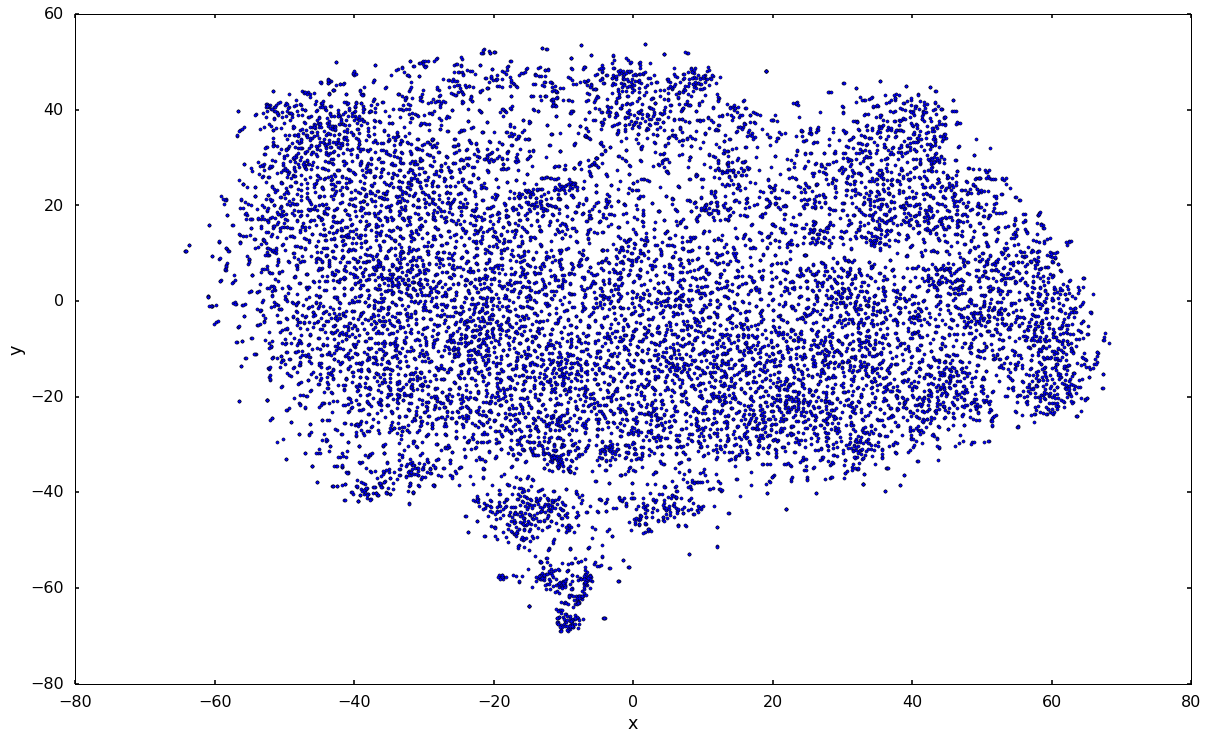

In [31]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [109]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

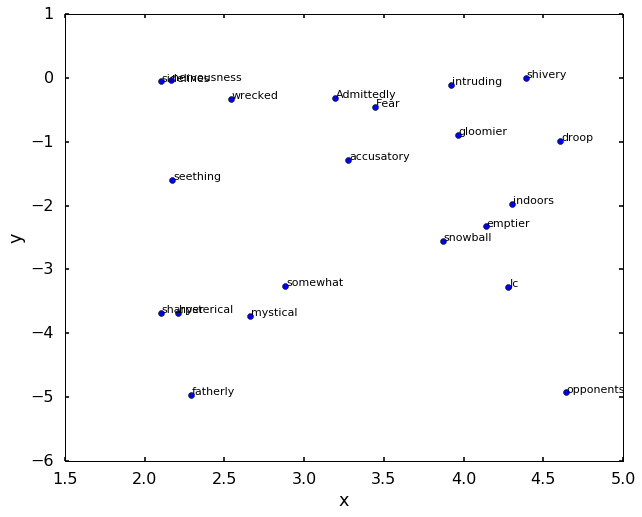

In [40]:
plot_region(x_bounds=(2.0, 5.0), y_bounds=(-5.0, 0.0))

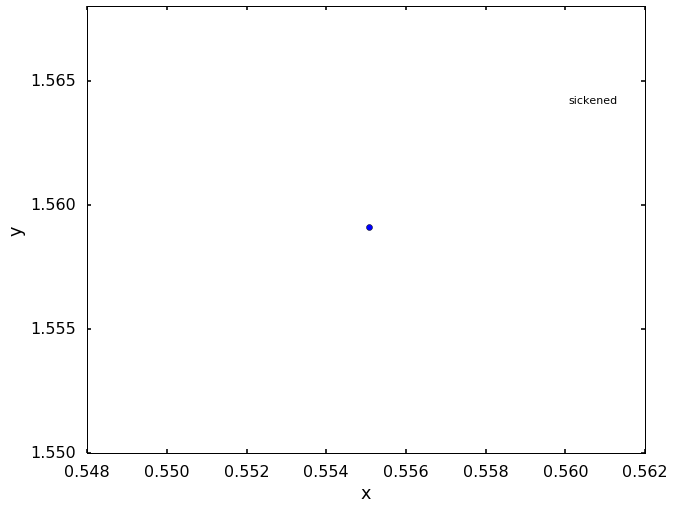

In [41]:
plot_region(x_bounds=(0, 1), y_bounds=(1, 2.5))

## visualize using Bokeh

In [96]:
from bokeh.plotting import figure 
from bokeh.io import output_notebook, show
from bokeh.models import (ColumnDataSource, LabelSet)

In [97]:
output_notebook()

Loading BokehJS ...

In [108]:
p = figure(plot_width=900, plot_height=800,
           title='HP2Vec')
source_labs = ColumnDataSource(data = points)
p.circle(points['x'],points['y'])
labels = LabelSet(x = 'x', y = 'y',
    text = 'word', source = source_labs,text_font_size='12pt')
# labels = LabelSet(x = 'x', y = 'y',text = 'word', source = source_labs,text_font_size='2pt')
p.add_layout(labels)

show(p)

## Let's test the model

In [46]:
hp2vec.wv.most_similar("snap")

[('shutting', 0.8820833563804626),
 ('sob', 0.8749580383300781),
 ('squeal', 0.8721970319747925),
 ('creak', 0.8715711832046509),
 ('thump', 0.8651505708694458),
 ('stall', 0.860087513923645),
 ('tap', 0.8588044047355652),
 ('tinkle', 0.8548915386199951),
 ('wailing', 0.853011429309845),
 ('crunching', 0.8521068096160889)]

In [47]:
hp2vec.wv.most_similar("wizard")

[('witch', 0.7035396695137024),
 ('man', 0.6522095799446106),
 ('Tri', 0.6464269161224365),
 ('thief', 0.6428224444389343),
 ('Marvolo', 0.6173789501190186),
 ('colleague', 0.6125411987304688),
 ('tufty', 0.6040909290313721),
 ('seeking', 0.6032334566116333),
 ('killer', 0.6015557050704956),
 ('teenage', 0.6014517545700073)]

In [61]:
hp2vec.wv.most_similar("Harry")

[('Fascinating', 0.680124044418335),
 ('Again', 0.6694284081459045),
 ('Show', 0.6526815891265869),
 ('Oy', 0.6490626335144043),
 ('LOVEGOOD', 0.6483889222145081),
 ('Tm', 0.6456639766693115),
 ('madness', 0.6433397531509399),
 ('Always', 0.6425763964653015),
 ('Mine', 0.6424661874771118),
 ('chorused', 0.6417523622512817)]

In [52]:
hp2vec.wv.most_similar("Potter")

[('Blood', 0.7866383790969849),
 ('Prisoner', 0.781068742275238),
 ('Half', 0.7795609831809998),
 ('Goblet', 0.7756674289703369),
 ('Philosophers', 0.7700759768486023),
 ('Deathly', 0.7694342732429504),
 ('Hallows', 0.7674713134765625),
 ('Secrets', 0.7631899118423462),
 ('Fire', 0.7629996538162231),
 ('Chamber', 0.7453452348709106)]

In [54]:
hp2vec.wv.most_similar("Hermione")

[('Lavender', 0.6308538317680359),
 ('Parvati', 0.6132867336273193),
 ('awkwardly', 0.6110005378723145),
 ('amazed', 0.6097816228866577),
 ('Ginny', 0.6049508452415466),
 ('incredulously', 0.6030745506286621),
 ('Luna', 0.6024337410926819),
 ('glumly', 0.5970892310142517),
 ('Myrtle', 0.5923687815666199),
 ('Cho', 0.5916386842727661)]

In [57]:
hp2vec.wv.most_similar("Voldemort")

[('Wormtail', 0.7398903965950012),
 ('Lord', 0.7315658330917358),
 ('thoughts', 0.6879923939704895),
 ('Bellatrix', 0.6776145100593567),
 ('Sorcerer', 0.6586010456085205),
 ('Frank', 0.6584743857383728),
 ('Riddle', 0.6548755168914795),
 ('prophecy', 0.6546200513839722),
 ('Elder', 0.6533874273300171),
 ('power', 0.6484763026237488)]

In [59]:
hp2vec.wv.most_similar('Dumbledore')

[('headmaster', 0.6973831057548523),
 ('Lupin', 0.6919794082641602),
 ('Slughorn', 0.6786898374557495),
 ('Riddle', 0.6744991540908813),
 ('Fudge', 0.6717173457145691),
 ('Karkaroff', 0.6491308212280273),
 ('Quirrell', 0.6475569009780884),
 ('Firenze', 0.6301932334899902),
 ('Dippet', 0.6190913319587708),
 ('Ariana', 0.6157576441764832)]

In [71]:
hp2vec.wv.most_similar('James')

[('Lily', 0.8188289403915405),
 ('Peter', 0.7812036275863647),
 ('father', 0.7459209561347961),
 ('Pettigrew', 0.7424709796905518),
 ('godfather', 0.7253893613815308),
 ('Avery', 0.7141839265823364),
 ('Black', 0.7111164927482605),
 ('Morfin', 0.707733690738678),
 ('arrested', 0.7063630223274231),
 ('Sirius', 0.7057400941848755)]

In [76]:
hp2vec.wv.similarity('Gryffindor','Ravenclaw')

0.7777041163126903

In [78]:
hp2vec.wv.similarity('Ravenclaw','Hufflepuff')

0.8629384763512468

In [79]:
hp2vec.wv.similarity('Gryffindor','Slytherin')

0.7373465039715053

In [80]:
hp2vec.wv.similarity('Harry','Hermione')

0.4193452797439988

In [81]:
hp2vec.wv.similarity('Harry','Ron')

0.46898045526495175

In [82]:
hp2vec.wv.similarity('Harry','Ginny')

0.46617392806242636

In [83]:
hp2vec.wv.similarity('Harry','Draco')

0.39859975121498703